In [1]:
import os
import cv2
import numpy as np
import torch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from typing import Optional
from small_gg import SmallGGAutoencoder

In [2]:
def show(chunk):
    """
    Given a 2-dimensional greyscale rep of an image, show it
    """
    plt.imshow(chunk, cmap="gray", vmin=0.0, vmax=1.0)
    plt.axis("off")
    plt.show()

def show2(chunk1, chunk2):
    """
    Given two 2-dimensional grayscale representations of images, show them side by side.
    """
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(chunk1.squeeze(), cmap="gray", vmin=0.0, vmax=1.0)
    axes[0].axis("off")
    axes[1].imshow(chunk2.squeeze(), cmap="gray", vmin=0.0, vmax=1.0)
    axes[1].axis("off")
    plt.show()

In [3]:
class SmallGGDataset(Dataset):
    """
    A dataset that loads images from a folder on the fly and serves 16x16 chunks.
    """
    def __init__(self, folder_path):
        self.filepaths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.png')]
        self.last_fx = 0
        self.current_image_chunks = self.get_chunks(self.filepaths[0])
        self.num_chunks_per_image = len(self.current_image_chunks)

    def __len__(self):
        return self.num_chunks_per_image * len(self.filepaths)

    def __getitem__(self, ix):
        fx = ix // self.num_chunks_per_image
        mx = ix % self.num_chunks_per_image
        if fx != self.last_fx:
            self.current_image_chunks = self.get_chunks(self.filepaths[fx])
        self.last_fx = fx
        return self.current_image_chunks[mx]

    def get_chunks(self, filepath, chunk_size=16, quantize=64):
        """
        Load an image and break it into 16x16 chunks.
        """
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        img = np.round(img * quantize) / quantize

        # Determine padding size
        height, width = img.shape[:2]
        pad_height = (chunk_size - height % chunk_size) % chunk_size
        pad_width = (chunk_size - width % chunk_size) % chunk_size

        # Pad image if necessary
        img = np.pad(img, ((0, pad_height), (0, pad_width)), mode="constant")

        # Reshape image into chunks
        chunks = [
            img[i : i + chunk_size, j : j + chunk_size]
            for i in range(0, img.shape[0], chunk_size)
            for j in range(0, img.shape[1], chunk_size)
        ]

        return [torch.from_numpy(chunk).unsqueeze(0) for chunk in chunks]

In [4]:
def evaluate_model(model, test_loader, criterion):
    """
    Helper function to evaluate a model against a dataloader
    """
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs = data
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            test_loss += loss.item() * inputs.size(0)
    return test_loss / len(test_loader.dataset)

def train_small_gg(
    model: "SmallGGAutoencoder",
    train_loader: DataLoader,
    test_loader: DataLoader,
    num_epochs: int,
    optimizer: Optional[optim.Adam]=None
) -> ((list[float], list[float]), optim.Adam):
    """
    Trains the given model on the given train/test datasets for the given number of epochs.
    Optionally takes an optimizer so you can continue to train by calling this function again.
    Returns tuple of three things:
        list of training losses
        list of testing losses
        the optimizer used (in case you want to keep training)
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001) if optimizer is None else optimizer
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            inputs = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        # Calculate average loss for training set
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Calculate average loss for test set
        test_loss = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return (train_losses, test_losses, optimizer)

In [5]:
# Initialize the model and the data loaders with 80-20 train test split
autoencoder = SmallGGAutoencoder()
dataset = SmallGGDataset("frames/i")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Also initialize the training ephemeral state for smart incremental training
optimizer = None
running_train_losses = []
running_test_losses = []

Epoch [1/100], Train Loss: 0.0665, Test Loss: 0.0683
Epoch [2/100], Train Loss: 0.0440, Test Loss: 0.0308
Epoch [3/100], Train Loss: 0.0201, Test Loss: 0.0196
Epoch [4/100], Train Loss: 0.0157, Test Loss: 0.0154
Epoch [5/100], Train Loss: 0.0140, Test Loss: 0.0125
Epoch [6/100], Train Loss: 0.0111, Test Loss: 0.0086
Epoch [7/100], Train Loss: 0.0097, Test Loss: 0.0088
Epoch [8/100], Train Loss: 0.0093, Test Loss: 0.0073
Epoch [9/100], Train Loss: 0.0087, Test Loss: 0.0072
Epoch [10/100], Train Loss: 0.0086, Test Loss: 0.0070
Epoch [11/100], Train Loss: 0.0078, Test Loss: 0.0064
Epoch [12/100], Train Loss: 0.0071, Test Loss: 0.0057
Epoch [13/100], Train Loss: 0.0066, Test Loss: 0.0054
Epoch [14/100], Train Loss: 0.0065, Test Loss: 0.0057
Epoch [15/100], Train Loss: 0.0066, Test Loss: 0.0055
Epoch [16/100], Train Loss: 0.0064, Test Loss: 0.0055
Epoch [17/100], Train Loss: 0.0069, Test Loss: 0.0063
Epoch [18/100], Train Loss: 0.0071, Test Loss: 0.0052
Epoch [19/100], Train Loss: 0.0061, T

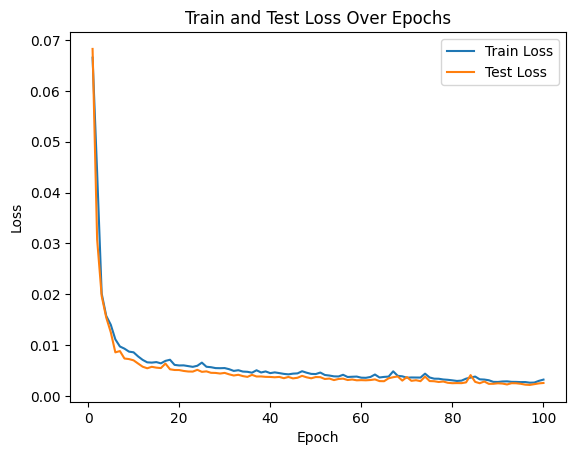

In [6]:
(new_train_losses, new_test_losses, optimizer) = train_small_gg(autoencoder, train_loader, test_loader, 100, optimizer)
running_train_losses.extend(new_train_losses)
running_test_losses.extend(new_test_losses)

# Plot the train and test loss
plt.plot(range(1, len(running_train_losses) + 1), running_train_losses, label='Train Loss')
plt.plot(range(1, len(running_test_losses) + 1), running_test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.show()

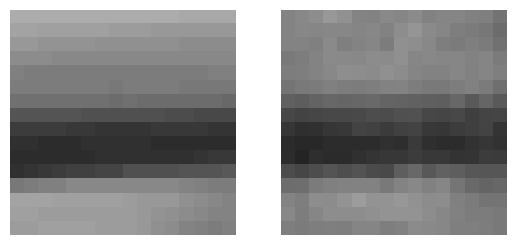

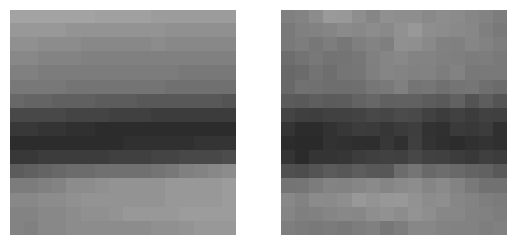

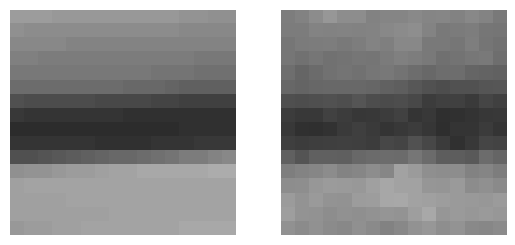

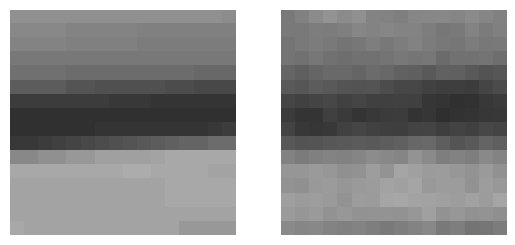

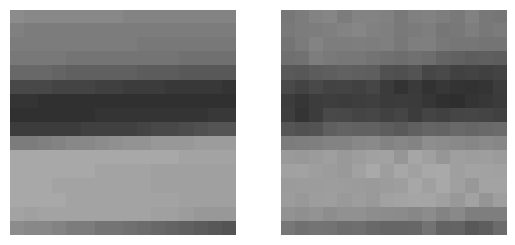

In [7]:
# Kind-of hacky cell for printing test-set reconstructions to verify performance visually
import random
NUM_SHOW = 5
for batch in train_loader:
    if random.random() > 0.1:
        continue
    for x in batch[:NUM_SHOW]:
        y = autoencoder.forward(x).detach().numpy()
        x = x.detach().numpy().reshape((16, 16))
        y = y.reshape((16, 16))
        show2(x, y)
    break

In [8]:
def reconstruct_image(model, image_path, chunk_size=16, quantize=64):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.round(img * quantize) / quantize

    # Determine padding size
    height, width = img.shape[:2]
    pad_height = (chunk_size - height % chunk_size) % chunk_size
    pad_width = (chunk_size - width % chunk_size) % chunk_size

    # Pad image if necessary
    img = np.pad(img, ((0, pad_height), (0, pad_width)), mode="constant")

    # Reshape image into chunks
    chunks = [
        img[i : i + chunk_size, j : j + chunk_size]
        for i in range(0, img.shape[0], chunk_size)
        for j in range(0, img.shape[1], chunk_size)
    ]

    # Convert each chunk into a tensor and reconstruct
    reconstructed_chunks = []
    for chunk in chunks:
        chunk_tensor = torch.from_numpy(chunk).unsqueeze(0).unsqueeze(0)
        reconstructed_chunk = model.forward(chunk_tensor).detach().numpy().reshape((chunk_size, chunk_size))
        reconstructed_chunks.append(reconstructed_chunk)

    # Calculate number of rows and columns for final image
    num_rows = int(height / chunk_size)
    num_cols = int(width / chunk_size)

    # Concatenate reconstructed chunks into final image
    reconstructed_image = np.concatenate([np.concatenate(reconstructed_chunks[i*num_cols:(i+1)*num_cols], axis=1) for i in range(num_rows)], axis=0)

    # Show original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(reconstructed_image, cmap="gray", vmin=0.0, vmax=1.0)
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")
    plt.show()

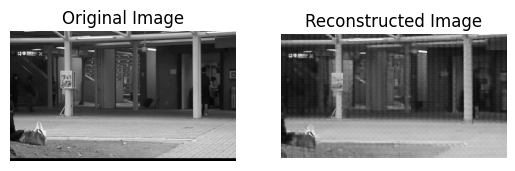

In [9]:
reconstruct_image(autoencoder, "frames/i/frame_750.png")